# Melting Uncertainties

This aims to estimate the uncertainty of the crystal melting rates,
combining the uncertainties of the dynamics and that of the rates calculation.
This requires an understanding of the errors in both
the melting rates, and in the rotational relaxation time.

In [1]:
import pandas
import uncertainties
import altair as alt
import numpy as np

import sys
sys.path.append("../src")
import figures

figures.use_my_theme()

## Error in Melting Rates

The first part of understanding the error in the melting rates
is establishing which errors are important.
In each melting simulation there is an error
in the fitted value for the melting rate.
Additionally there is an error
in measuring the rate between experiments,
with each having a slightly different rate.
The approach here is to evaluate what these errors actually look like.

In [2]:
with pandas.HDFStore('../data/analysis/melting_clean.h5') as store:
    rates_df = store.get("rates")

In calculating the errors we are going to use
two standard deviations for the depiction of the errors.

In [3]:
rates_df["error_min"] = rates_df["mean"] - 2*rates_df["error"]
rates_df["error_max"] = rates_df["mean"] + 2*rates_df["error"]

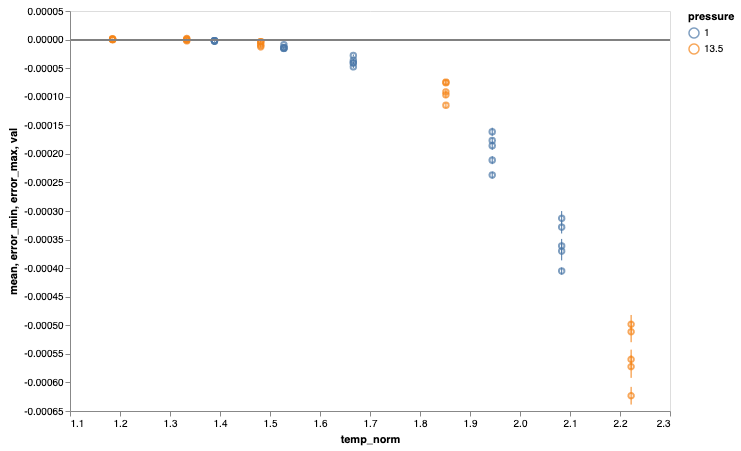

In [4]:
chart = alt.Chart(rates_df).encode(
    x=alt.X("temp_norm", scale=alt.Scale(zero=False)),
    color="pressure:N",
)

chart = chart.mark_point().encode(y="mean") + chart.mark_rule().encode(y="error_min", y2="error_max")
chart = figures.hline(chart, 0)
chart

The figure above shows the errors of the individual samples
indicated as the error bars on each point
and the error between simulation replications,
which is the spread of the dots at a specific temperature.
This figure shows that the errors
in finding the melting rate for each simulation
are orders of magnitude smaller than the errors between simulations.
This means that we can effectively ignore the error in measurement,
only using the error between measurements.

With the error between the measurements being
the largest contribution to the overall error
we can estimate the error in the melting rates
as the standard deviation of the measurements.

In [5]:
melt_value = rates_df.groupby(["temperature","pressure", "temp_norm"])["mean"].mean()
melt_err = rates_df.groupby(["temperature", "pressure", "temp_norm"])["mean"].std()
melt_frac_err = melt_err / melt_value
melt_df = pandas.DataFrame({
    "value": melt_value,
    "error": melt_err,
    "error_frac": melt_frac_err,
    "error_min": melt_value - 2 * melt_err,
    "error_max": melt_value + 2 * melt_err,
})

The resulting errors, plotted as 2 * the standard deviation
are shown in the figure below.

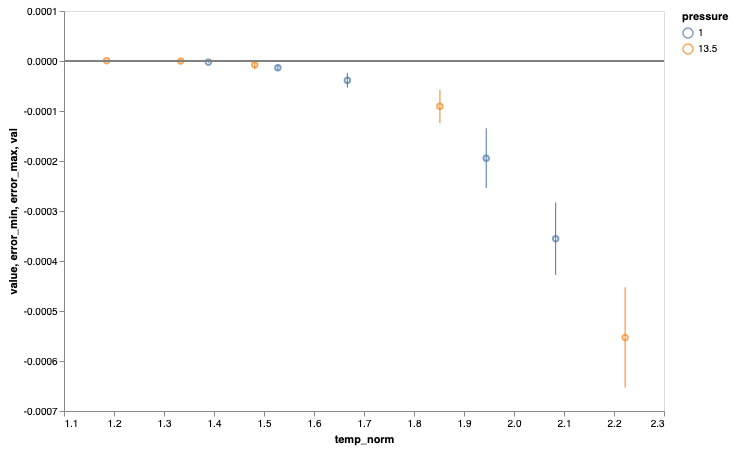

In [6]:
chart = alt.Chart(melt_df.reset_index()).encode(
    x=alt.X("temp_norm", scale=alt.Scale(zero=False)),
    color="pressure:N",
)

chart = chart.mark_point().encode(y="value") + chart.mark_rule().encode(y="error_min", y2="error_max")
chart = figures.hline(chart, 0)
chart

## Error in Rotational Relaxation

The errors in the rotational relaxation
have already been calculated using bootstrapping,
which has resulted in asymmetrical errors.
While there is some precedence
for asymmetrical errors,
this approach is complicated.
An alternative is to assume a asymmetrical distribution
with the characteristics of the larger asymmetric error,
which will over-estimate some of the error,
however this is not necessarily a huge issue,
and in this case an estimation I am willing to make.

In [7]:
with pandas.HDFStore('../data/analysis/dynamics_clean_agg.h5') as store:
    relax_df = store.get("relaxations")

In [8]:
rot_value = relax_df.groupby(["temperature", "pressure"])["rot2_value"].mean()
rot_err = np.maximum((relax_df["rot2_value"] - relax_df["rot2_lower"]).values, (relax_df["rot2_upper"] - relax_df["rot2_value"]).values)
rot_frac_err = rot_err / rot_value

rot_df = pandas.DataFrame({
    "value": rot_value,
    "error": rot_err,
    "error_frac": rot_frac_err,
})

## Combined Errors

Combining the rotational relaxation
and the melting rate is through a multiplication,
making the combination of errors being
the sum of the error fractions.

In [9]:
all_df = melt_df.reset_index("temp_norm").join(rot_df, lsuffix="_melt", rsuffix="_rot").set_index('temp_norm', append=True)
all_df.head()

,,,value_melt,error_melt,error_frac_melt,error_min,error_max,value_rot,error_rot,error_frac_rot
temperature,pressure,temp_norm,,,,,,,,
0.50,1.0,1.388889,-0.000002,5.687361e-07,-0.243847,-0.000003,-0.000001,58404.0,516.3,0.008840
0.55,1.0,1.527778,-0.000014,2.629955e-06,-0.194070,-0.000019,-0.000008,35660.0,400.0,0.011217
0.60,1.0,1.666667,-0.000039,7.319678e-06,-0.189497,-0.000053,-0.000024,22080.0,280.0,0.012681
0.70,1.0,1.944444,-0.000194,2.992831e-05,-0.153981,-0.000254,-0.000135,12680.0,301.0,0.023738
0.75,1.0,2.083333,-0.000356,3.631051e-05,-0.102123,-0.000428,-0.000283,NaN,NaN,NaN


In [10]:
value = all_df["value_melt"] * all_df["value_rot"]
err_frac = all_df["error_frac_melt"].abs() + all_df["error_frac_rot"].abs()
error = value * err_frac

melt_values = pandas.DataFrame({
    "value": value,
    "error_min": value - 2 * error,
    "error_max": value + 2 * error,
})

With the errors combined we get the resulting figure,
now including the errors in the measurement.

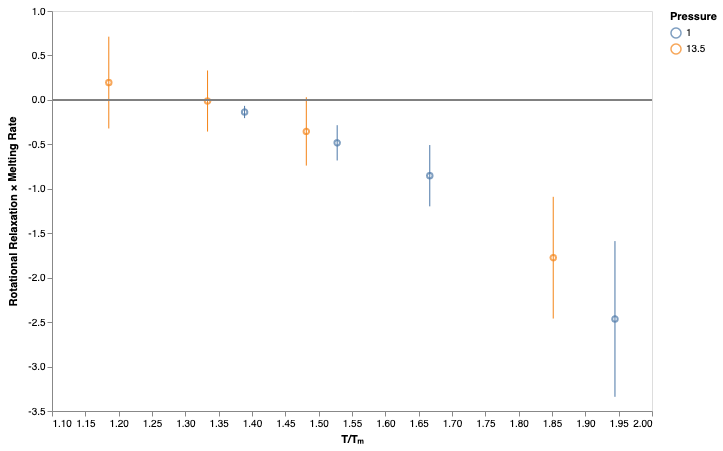

In [11]:
chart = alt.Chart(melt_values.reset_index()).encode(
    x=alt.X("temp_norm", title="T/Tₘ", scale=alt.Scale(zero=False)),
    color=alt.Color("pressure:N", title="Pressure"),
)

c = (
    chart.mark_point().encode(y=alt.Y("value", title="Rotational Relaxation × Melting Rate")) +
    chart.mark_rule().encode(y="error_min", y2="error_max")
)

c = figures.hline(c, 0)
c

In [12]:
c.save("../figures/normalised_melting_err.svg", webdriver="firefox")